In [21]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader

device = 'cuda'

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

datasets = {
    'train': MNIST(root='data', train=True, download=True, transform=transform),
    'test': MNIST(root='data', train=False, download=True, transform=transform)
}

loaders = {
    'train': DataLoader(dataset=datasets['train'],batch_size=64,shuffle=True, pin_memory=True, pin_memory_device=device, num_workers=4),
    'test': DataLoader(dataset=datasets['test'],batch_size=64,shuffle=False, pin_memory=True, pin_memory_device=device, num_workers=4)
}

In [22]:
from torch import Tensor
from torch.nn import Module
from torch.nn import Flatten,  Sequential
from torch.nn import Linear, ReLU, Dropout
from model.dropconnect import DropConnectLinear, DropConnectBatchAverage

class Perceptron(Module):
    def __init__(self, input_features: int, hidden_dimension: int, output_features: int, p: float):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            Linear(input_features, hidden_dimension),
            ReLU(),
            Dropout(p),
            Linear(hidden_dimension, output_features),
        )

    def forward(self, input: Tensor) -> Tensor:
        input = self.flatten(input)
        return self.layers(input)
            

class DropConnectPerceptron(Module):
    def __init__(self, input_features: int, hidden_dimension: int, output_features: int, p: float):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            DropConnectLinear(input_features, hidden_dimension, p=p),
            ReLU(),
            DropConnectBatchAverage(),
            DropConnectLinear(hidden_dimension, output_features, p=p),
            ReLU(),
            DropConnectBatchAverage()
        )

    def forward(self, input: Tensor) -> Tensor:
        input = self.flatten(input)
        return self.layers(input)

In [23]:
import torch
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from utils import train, test, Metrics

In [24]:
from typing import Dict
from typing import Optional
from matplotlib.pyplot import figure, show
from matplotlib.axes import Axes

def plot(metrics: Dict[str, Metrics], metric: str, ax: Optional[Axes] = None) -> Axes:
    if ax is None:
        plot = figure()
        ax = plot.add_subplot()

    for key, value in metrics.items():
        ax.plot(value.history[metric], label=key)
    ax.legend()
    ax.set_title(metric)
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)
    return ax

Processed 938 batches, average loss: 0.3703, average accuracy: 0.8902, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1761, average accuracy: 0.9483, in epoch 1 for test mode
Processed 938 batches, average loss: 0.1637, average accuracy: 0.9515, in epoch 2 for train mode
Processed 157 batches, average loss: 0.1170, average accuracy: 0.9663, in epoch 2 for test mode
Processed 938 batches, average loss: 0.1202, average accuracy: 0.9644, in epoch 3 for train mode
Processed 157 batches, average loss: 0.1002, average accuracy: 0.9706, in epoch 3 for test mode
Processed 938 batches, average loss: 0.0983, average accuracy: 0.9702, in epoch 4 for train mode
Processed 157 batches, average loss: 0.0888, average accuracy: 0.9733, in epoch 4 for test mode
Processed 938 batches, average loss: 0.0823, average accuracy: 0.9751, in epoch 5 for train mode
Processed 157 batches, average loss: 0.0815, average accuracy: 0.9765, in epoch 5 for test mode
Processed 938 batches, average loss

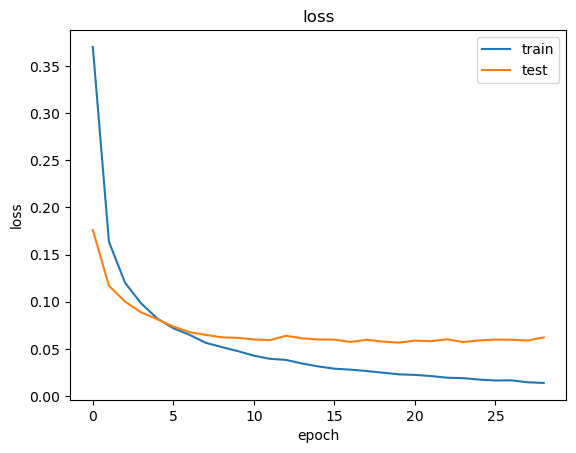

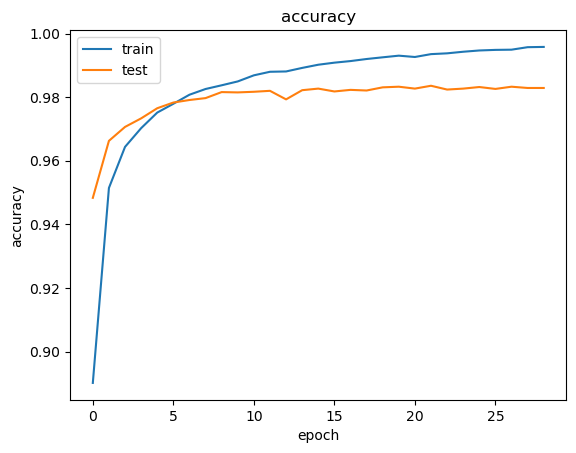

In [25]:
model = DropConnectPerceptron(28*28, 256, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.2829, average accuracy: 0.9154, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1290, average accuracy: 0.9599, in epoch 1 for test mode
Processed 938 batches, average loss: 0.1248, average accuracy: 0.9629, in epoch 2 for train mode
Processed 157 batches, average loss: 0.0956, average accuracy: 0.9718, in epoch 2 for test mode
Processed 938 batches, average loss: 0.0922, average accuracy: 0.9726, in epoch 3 for train mode
Processed 157 batches, average loss: 0.0778, average accuracy: 0.9755, in epoch 3 for test mode
Processed 938 batches, average loss: 0.0729, average accuracy: 0.9781, in epoch 4 for train mode
Processed 157 batches, average loss: 0.0707, average accuracy: 0.9778, in epoch 4 for test mode
Processed 938 batches, average loss: 0.0614, average accuracy: 0.9812, in epoch 5 for train mode
Processed 157 batches, average loss: 0.0694, average accuracy: 0.9795, in epoch 5 for test mode
Processed 938 batches, average loss

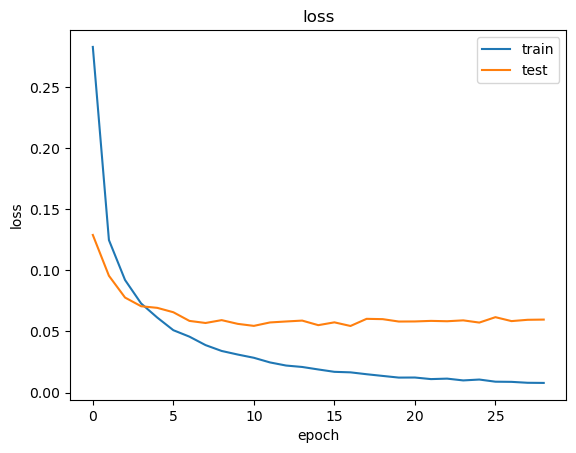

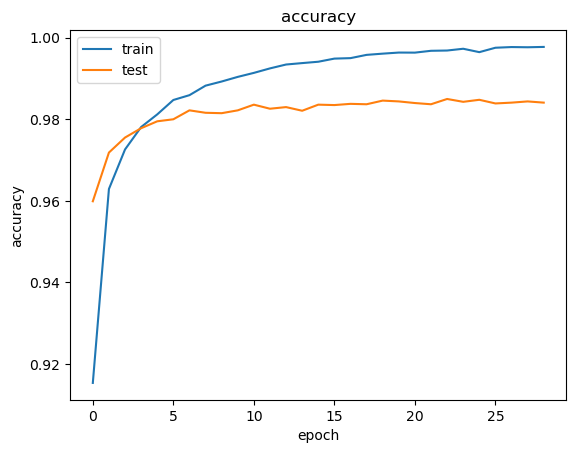

In [26]:
model = Perceptron(28*28, 256, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.6131, average accuracy: 0.8159, in epoch 1 for train mode
Processed 157 batches, average loss: 0.2846, average accuracy: 0.9166, in epoch 1 for test mode
Processed 938 batches, average loss: 0.2869, average accuracy: 0.9158, in epoch 2 for train mode
Processed 157 batches, average loss: 0.2199, average accuracy: 0.9380, in epoch 2 for test mode
Processed 938 batches, average loss: 0.2325, average accuracy: 0.9318, in epoch 3 for train mode
Processed 157 batches, average loss: 0.1843, average accuracy: 0.9467, in epoch 3 for test mode
Processed 938 batches, average loss: 0.2000, average accuracy: 0.9408, in epoch 4 for train mode
Processed 157 batches, average loss: 0.1578, average accuracy: 0.9542, in epoch 4 for test mode
Processed 938 batches, average loss: 0.1764, average accuracy: 0.9475, in epoch 5 for train mode
Processed 157 batches, average loss: 0.1433, average accuracy: 0.9574, in epoch 5 for test mode
Processed 938 batches, average loss

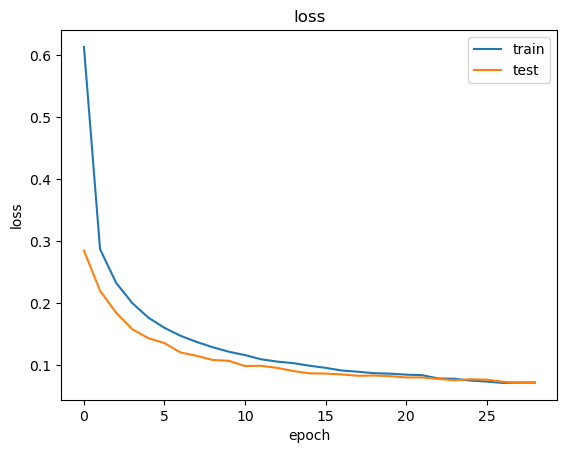

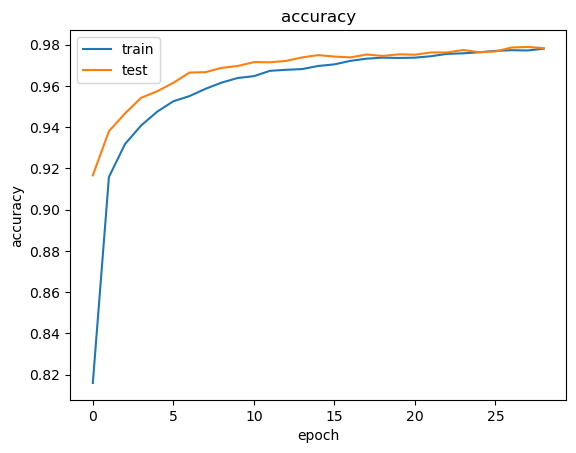

In [27]:
model = DropConnectPerceptron(28*28, 256, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.3376, average accuracy: 0.8977, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1405, average accuracy: 0.9565, in epoch 1 for test mode
Processed 938 batches, average loss: 0.1724, average accuracy: 0.9489, in epoch 2 for train mode
Processed 157 batches, average loss: 0.1011, average accuracy: 0.9699, in epoch 2 for test mode
Processed 938 batches, average loss: 0.1393, average accuracy: 0.9585, in epoch 3 for train mode
Processed 157 batches, average loss: 0.0875, average accuracy: 0.9725, in epoch 3 for test mode
Processed 938 batches, average loss: 0.1213, average accuracy: 0.9627, in epoch 4 for train mode
Processed 157 batches, average loss: 0.0807, average accuracy: 0.9754, in epoch 4 for test mode
Processed 938 batches, average loss: 0.1042, average accuracy: 0.9685, in epoch 5 for train mode
Processed 157 batches, average loss: 0.0758, average accuracy: 0.9773, in epoch 5 for test mode
Processed 938 batches, average loss

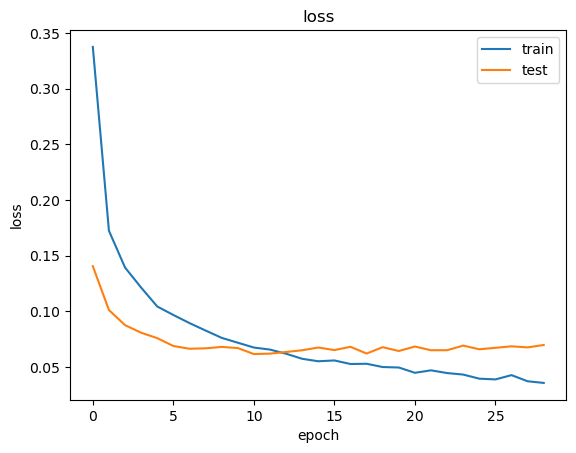

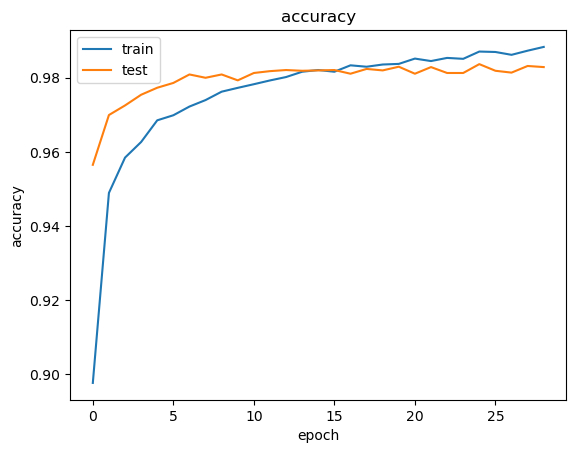

In [28]:
model = Perceptron(28*28, 256, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.3435, average accuracy: 0.8977, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1639, average accuracy: 0.9512, in epoch 1 for test mode
Processed 938 batches, average loss: 0.1507, average accuracy: 0.9562, in epoch 2 for train mode
Processed 157 batches, average loss: 0.1101, average accuracy: 0.9670, in epoch 2 for test mode
Processed 938 batches, average loss: 0.1077, average accuracy: 0.9680, in epoch 3 for train mode
Processed 157 batches, average loss: 0.0914, average accuracy: 0.9726, in epoch 3 for test mode
Processed 938 batches, average loss: 0.0870, average accuracy: 0.9740, in epoch 4 for train mode
Processed 157 batches, average loss: 0.0800, average accuracy: 0.9750, in epoch 4 for test mode
Processed 938 batches, average loss: 0.0722, average accuracy: 0.9784, in epoch 5 for train mode
Processed 157 batches, average loss: 0.0743, average accuracy: 0.9764, in epoch 5 for test mode
Processed 938 batches, average loss

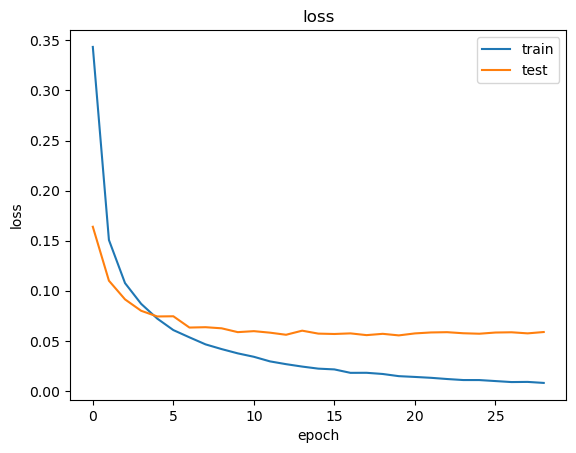

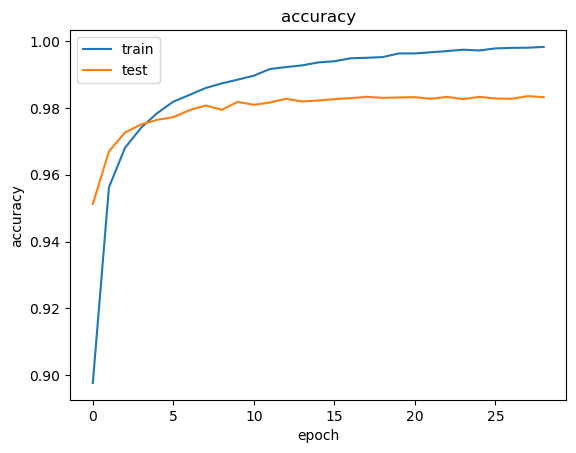

In [29]:
model = DropConnectPerceptron(28*28, 512, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.2659, average accuracy: 0.9212, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1241, average accuracy: 0.9653, in epoch 1 for test mode
Processed 938 batches, average loss: 0.1125, average accuracy: 0.9675, in epoch 2 for train mode
Processed 157 batches, average loss: 0.0861, average accuracy: 0.9749, in epoch 2 for test mode
Processed 938 batches, average loss: 0.0799, average accuracy: 0.9761, in epoch 3 for train mode
Processed 157 batches, average loss: 0.0765, average accuracy: 0.9763, in epoch 3 for test mode
Processed 938 batches, average loss: 0.0625, average accuracy: 0.9809, in epoch 4 for train mode
Processed 157 batches, average loss: 0.0693, average accuracy: 0.9783, in epoch 4 for test mode
Processed 938 batches, average loss: 0.0491, average accuracy: 0.9855, in epoch 5 for train mode
Processed 157 batches, average loss: 0.0638, average accuracy: 0.9804, in epoch 5 for test mode
Processed 938 batches, average loss

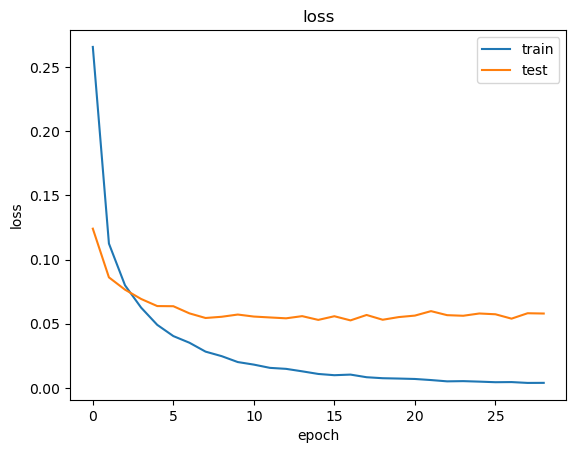

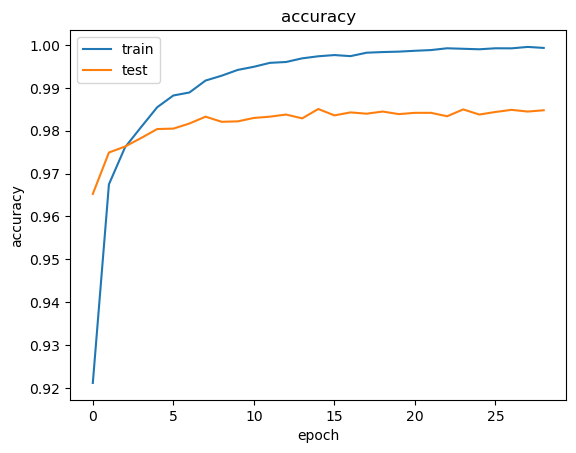

In [30]:
model = Perceptron(28*28, 512, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.6008, average accuracy: 0.8208, in epoch 1 for train mode
Processed 157 batches, average loss: 0.2789, average accuracy: 0.9221, in epoch 1 for test mode
Processed 938 batches, average loss: 0.2771, average accuracy: 0.9176, in epoch 2 for train mode
Processed 157 batches, average loss: 0.2142, average accuracy: 0.9403, in epoch 2 for test mode
Processed 938 batches, average loss: 0.2201, average accuracy: 0.9352, in epoch 3 for train mode
Processed 157 batches, average loss: 0.1803, average accuracy: 0.9471, in epoch 3 for test mode
Processed 938 batches, average loss: 0.1848, average accuracy: 0.9452, in epoch 4 for train mode
Processed 157 batches, average loss: 0.1520, average accuracy: 0.9560, in epoch 4 for test mode
Processed 938 batches, average loss: 0.1589, average accuracy: 0.9535, in epoch 5 for train mode
Processed 157 batches, average loss: 0.1327, average accuracy: 0.9612, in epoch 5 for test mode
Processed 938 batches, average loss

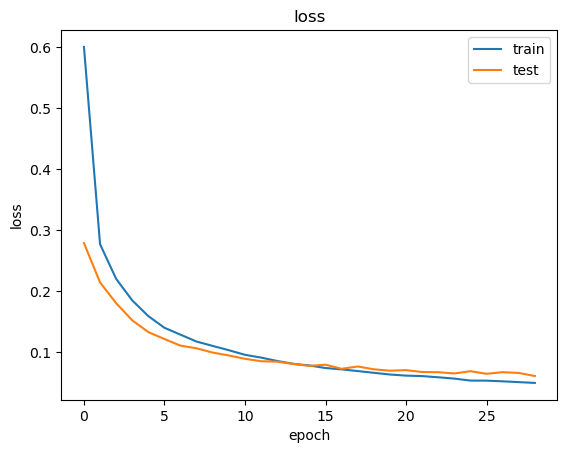

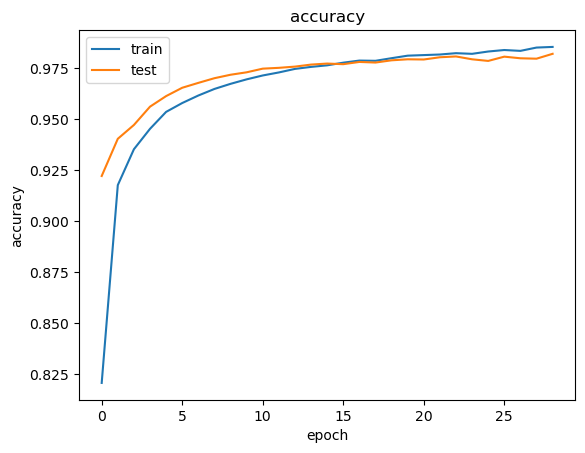

In [31]:
model = DropConnectPerceptron(28*28, 512, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.3019, average accuracy: 0.9091, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1322, average accuracy: 0.9615, in epoch 1 for test mode
Processed 938 batches, average loss: 0.1487, average accuracy: 0.9561, in epoch 2 for train mode
Processed 157 batches, average loss: 0.0926, average accuracy: 0.9705, in epoch 2 for test mode
Processed 938 batches, average loss: 0.1107, average accuracy: 0.9663, in epoch 3 for train mode
Processed 157 batches, average loss: 0.0825, average accuracy: 0.9743, in epoch 3 for test mode
Processed 938 batches, average loss: 0.0949, average accuracy: 0.9708, in epoch 4 for train mode
Processed 157 batches, average loss: 0.0703, average accuracy: 0.9792, in epoch 4 for test mode
Processed 938 batches, average loss: 0.0809, average accuracy: 0.9749, in epoch 5 for train mode
Processed 157 batches, average loss: 0.0705, average accuracy: 0.9779, in epoch 5 for test mode
Processed 938 batches, average loss

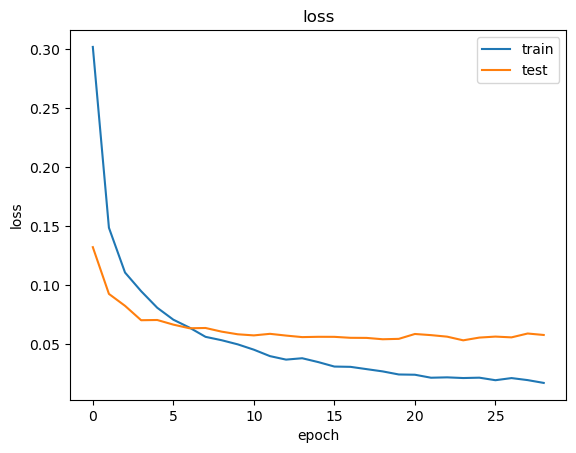

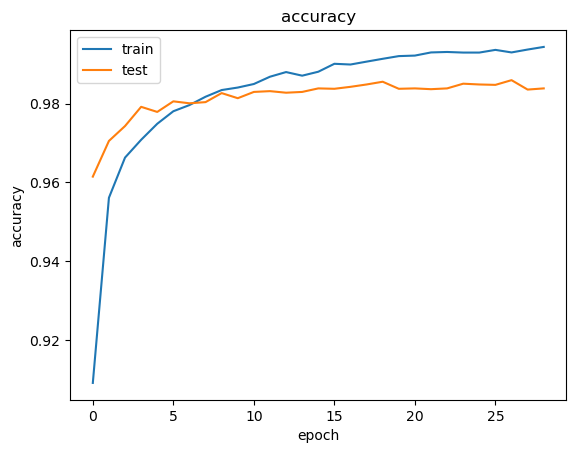

In [32]:
model = Perceptron(28*28, 512, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.7841, average accuracy: 0.7277, in epoch 1 for train mode
Processed 157 batches, average loss: 0.4965, average accuracy: 0.8392, in epoch 1 for test mode
Processed 938 batches, average loss: 0.3742, average accuracy: 0.9068, in epoch 2 for train mode
Processed 157 batches, average loss: 0.2069, average accuracy: 0.9508, in epoch 2 for test mode
Processed 938 batches, average loss: 0.2955, average accuracy: 0.9301, in epoch 3 for train mode
Processed 157 batches, average loss: 0.1846, average accuracy: 0.9569, in epoch 3 for test mode
Processed 938 batches, average loss: 0.2697, average accuracy: 0.9367, in epoch 4 for train mode
Processed 157 batches, average loss: 0.1871, average accuracy: 0.9560, in epoch 4 for test mode
Processed 938 batches, average loss: 0.2646, average accuracy: 0.9381, in epoch 5 for train mode
Processed 157 batches, average loss: 0.1865, average accuracy: 0.9561, in epoch 5 for test mode
Processed 938 batches, average loss

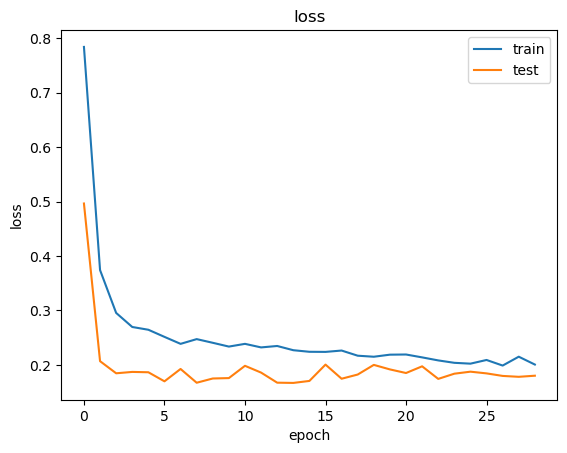

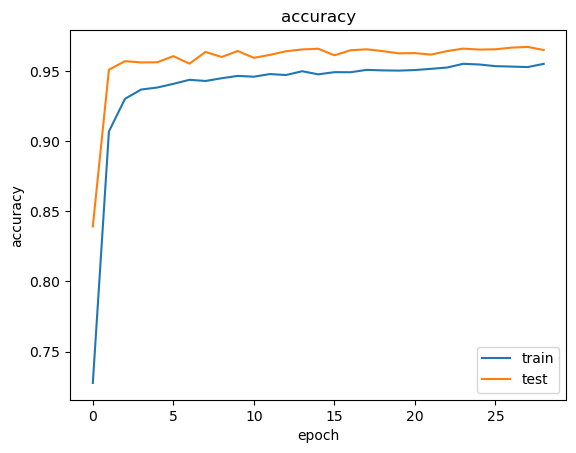

In [33]:
model = DropConnectPerceptron(28*28, 256, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.3888, average accuracy: 0.8879, in epoch 1 for train mode
Processed 157 batches, average loss: 0.1980, average accuracy: 0.9419, in epoch 1 for test mode
Processed 938 batches, average loss: 0.3215, average accuracy: 0.9115, in epoch 2 for train mode
Processed 157 batches, average loss: 0.3089, average accuracy: 0.9207, in epoch 2 for test mode
Processed 938 batches, average loss: 0.3087, average accuracy: 0.9170, in epoch 3 for train mode
Processed 157 batches, average loss: 0.2103, average accuracy: 0.9474, in epoch 3 for test mode
Processed 938 batches, average loss: 0.2907, average accuracy: 0.9228, in epoch 4 for train mode
Processed 157 batches, average loss: 0.2181, average accuracy: 0.9427, in epoch 4 for test mode
Processed 938 batches, average loss: 0.2858, average accuracy: 0.9239, in epoch 5 for train mode
Processed 157 batches, average loss: 0.2104, average accuracy: 0.9485, in epoch 5 for test mode
Processed 938 batches, average loss

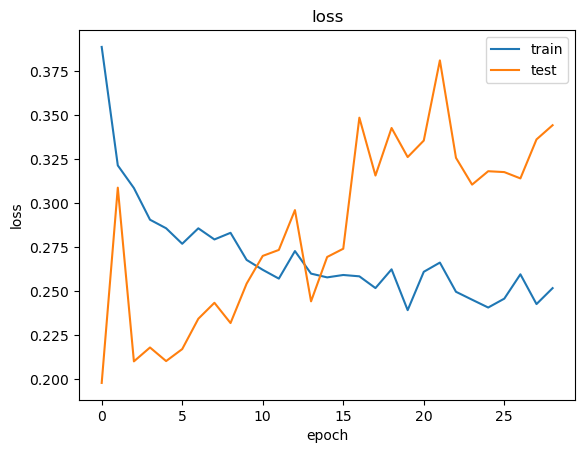

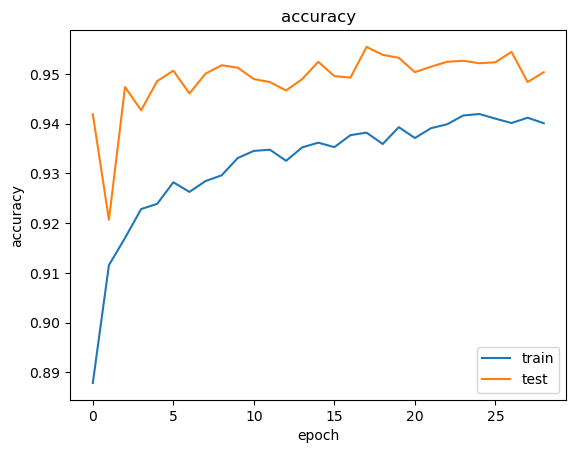

In [34]:
model = Perceptron(28*28, 256, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 1.0077, average accuracy: 0.6451, in epoch 1 for train mode
Processed 157 batches, average loss: 0.8449, average accuracy: 0.6872, in epoch 1 for test mode
Processed 938 batches, average loss: 0.9426, average accuracy: 0.6584, in epoch 2 for train mode
Processed 157 batches, average loss: 0.8165, average accuracy: 0.6953, in epoch 2 for test mode
Processed 938 batches, average loss: 0.8787, average accuracy: 0.6926, in epoch 3 for train mode
Processed 157 batches, average loss: 0.5119, average accuracy: 0.8463, in epoch 3 for test mode
Processed 938 batches, average loss: 0.6523, average accuracy: 0.8026, in epoch 4 for train mode
Processed 157 batches, average loss: 0.4592, average accuracy: 0.8603, in epoch 4 for test mode
Processed 938 batches, average loss: 0.5896, average accuracy: 0.8179, in epoch 5 for train mode
Processed 157 batches, average loss: 0.4348, average accuracy: 0.8662, in epoch 5 for test mode
Processed 938 batches, average loss

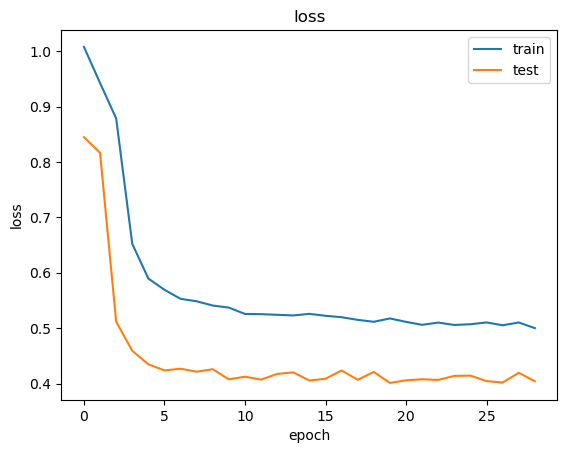

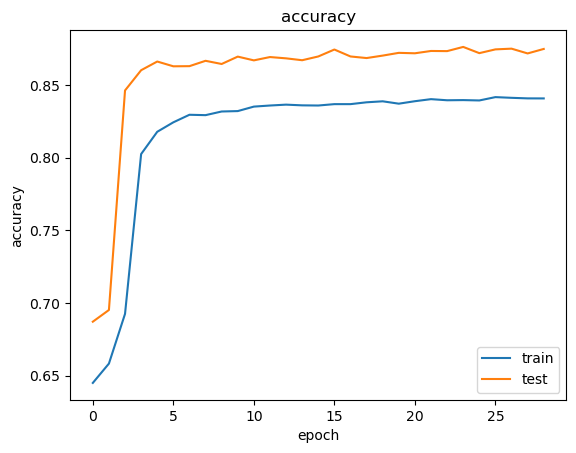

In [35]:
model = DropConnectPerceptron(28*28, 256, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.6335, average accuracy: 0.8150, in epoch 1 for train mode
Processed 157 batches, average loss: 0.2969, average accuracy: 0.9208, in epoch 1 for test mode
Processed 938 batches, average loss: 0.5562, average accuracy: 0.8451, in epoch 2 for train mode
Processed 157 batches, average loss: 0.2845, average accuracy: 0.9309, in epoch 2 for test mode
Processed 938 batches, average loss: 0.5539, average accuracy: 0.8487, in epoch 3 for train mode
Processed 157 batches, average loss: 0.2759, average accuracy: 0.9301, in epoch 3 for test mode
Processed 938 batches, average loss: 0.5595, average accuracy: 0.8497, in epoch 4 for train mode
Processed 157 batches, average loss: 0.2901, average accuracy: 0.9332, in epoch 4 for test mode
Processed 938 batches, average loss: 0.5556, average accuracy: 0.8500, in epoch 5 for train mode
Processed 157 batches, average loss: 0.2767, average accuracy: 0.9361, in epoch 5 for test mode
Processed 938 batches, average loss

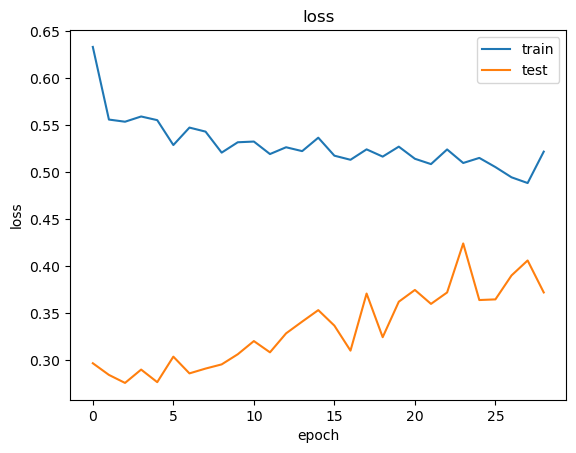

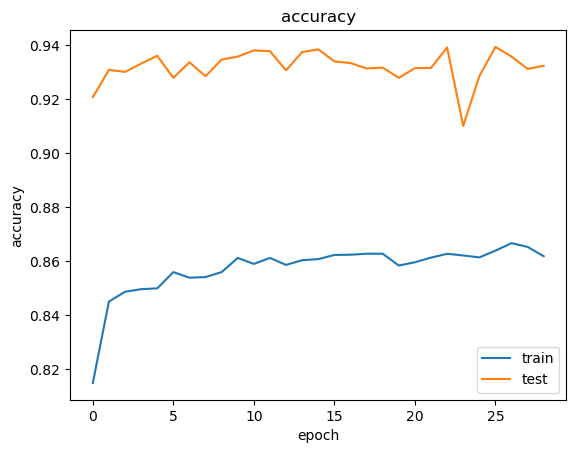

In [36]:
model = Perceptron(28*28, 256, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 2.3071, average accuracy: 0.0989, in epoch 1 for train mode
Processed 157 batches, average loss: 2.3026, average accuracy: 0.0978, in epoch 1 for test mode
Processed 938 batches, average loss: 2.3026, average accuracy: 0.0987, in epoch 2 for train mode
Processed 157 batches, average loss: 2.3026, average accuracy: 0.0978, in epoch 2 for test mode
Processed 938 batches, average loss: 2.3026, average accuracy: 0.0987, in epoch 3 for train mode
Processed 157 batches, average loss: 2.3026, average accuracy: 0.0978, in epoch 3 for test mode
Processed 938 batches, average loss: 2.3026, average accuracy: 0.0987, in epoch 4 for train mode
Processed 157 batches, average loss: 2.3026, average accuracy: 0.0978, in epoch 4 for test mode
Processed 938 batches, average loss: 2.3026, average accuracy: 0.0987, in epoch 5 for train mode
Processed 157 batches, average loss: 2.3026, average accuracy: 0.0978, in epoch 5 for test mode
Processed 938 batches, average loss

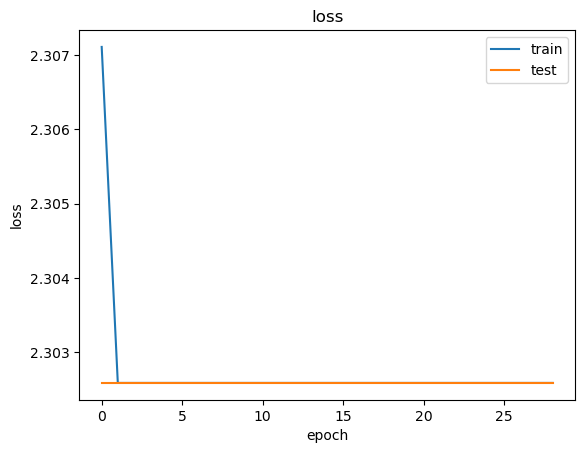

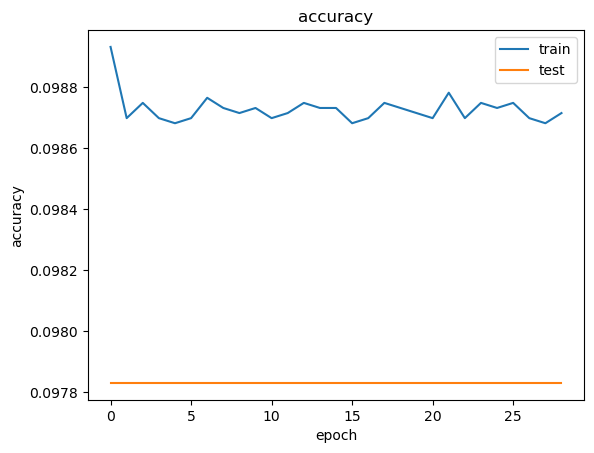

In [37]:
model = DropConnectPerceptron(28*28, 512, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.3793, average accuracy: 0.8949, in epoch 1 for train mode
Processed 157 batches, average loss: 0.2155, average accuracy: 0.9420, in epoch 1 for test mode
Processed 938 batches, average loss: 0.3139, average accuracy: 0.9152, in epoch 2 for train mode
Processed 157 batches, average loss: 0.2373, average accuracy: 0.9401, in epoch 2 for test mode
Processed 938 batches, average loss: 0.2965, average accuracy: 0.9223, in epoch 3 for train mode
Processed 157 batches, average loss: 0.2030, average accuracy: 0.9454, in epoch 3 for test mode
Processed 938 batches, average loss: 0.2871, average accuracy: 0.9269, in epoch 4 for train mode
Processed 157 batches, average loss: 0.2126, average accuracy: 0.9499, in epoch 4 for test mode
Processed 938 batches, average loss: 0.2852, average accuracy: 0.9281, in epoch 5 for train mode
Processed 157 batches, average loss: 0.2300, average accuracy: 0.9487, in epoch 5 for test mode
Processed 938 batches, average loss

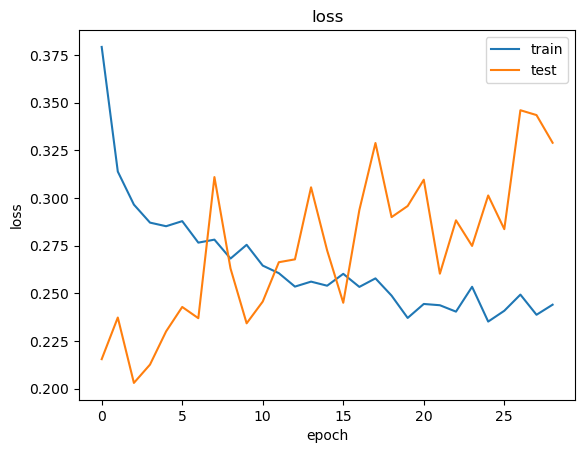

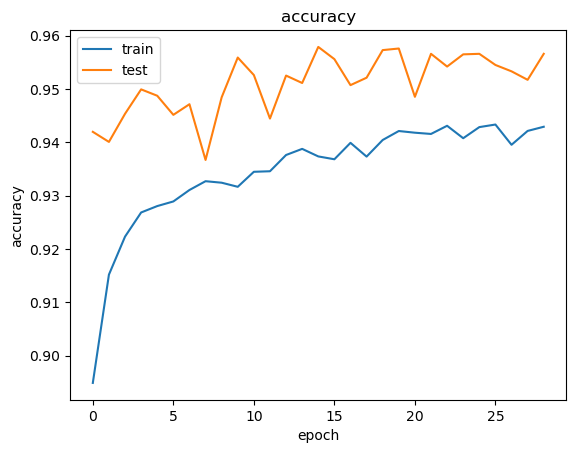

In [38]:
model = Perceptron(28*28, 512, 10, 0.2).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 1.9900, average accuracy: 0.2399, in epoch 1 for train mode
Processed 157 batches, average loss: 1.7600, average accuracy: 0.2872, in epoch 1 for test mode
Processed 938 batches, average loss: 1.8466, average accuracy: 0.2486, in epoch 2 for train mode
Processed 157 batches, average loss: 1.7385, average accuracy: 0.2973, in epoch 2 for test mode
Processed 938 batches, average loss: 1.8197, average accuracy: 0.2534, in epoch 3 for train mode
Processed 157 batches, average loss: 1.7276, average accuracy: 0.3046, in epoch 3 for test mode
Processed 938 batches, average loss: 1.7960, average accuracy: 0.2570, in epoch 4 for train mode
Processed 157 batches, average loss: 1.7060, average accuracy: 0.3042, in epoch 4 for test mode
Processed 938 batches, average loss: 1.7936, average accuracy: 0.2579, in epoch 5 for train mode
Processed 157 batches, average loss: 1.6878, average accuracy: 0.3601, in epoch 5 for test mode
Processed 938 batches, average loss

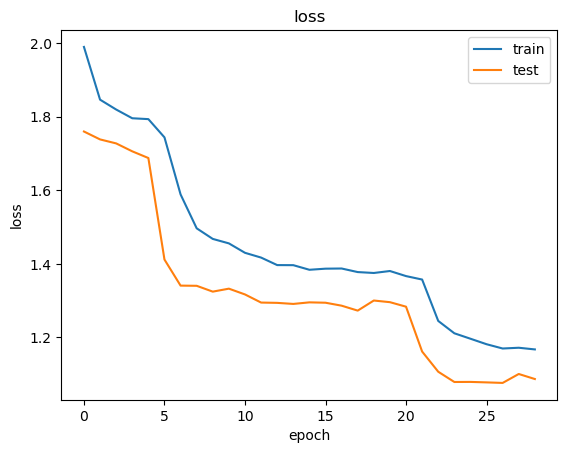

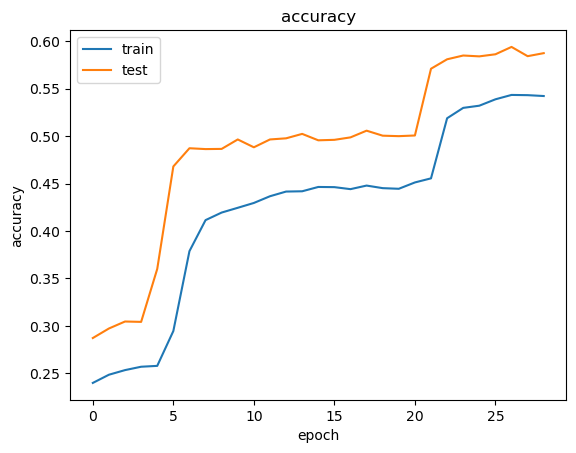

In [39]:
model = DropConnectPerceptron(28*28, 512, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()

Processed 938 batches, average loss: 0.6092, average accuracy: 0.8292, in epoch 1 for train mode
Processed 157 batches, average loss: 0.2991, average accuracy: 0.9161, in epoch 1 for test mode
Processed 938 batches, average loss: 0.5809, average accuracy: 0.8444, in epoch 2 for train mode
Processed 157 batches, average loss: 0.2980, average accuracy: 0.9240, in epoch 2 for test mode
Processed 938 batches, average loss: 0.5486, average accuracy: 0.8555, in epoch 3 for train mode
Processed 157 batches, average loss: 0.3102, average accuracy: 0.9254, in epoch 3 for test mode
Processed 938 batches, average loss: 0.5444, average accuracy: 0.8597, in epoch 4 for train mode
Processed 157 batches, average loss: 0.3136, average accuracy: 0.9259, in epoch 4 for test mode
Processed 938 batches, average loss: 0.5444, average accuracy: 0.8597, in epoch 5 for train mode
Processed 157 batches, average loss: 0.2985, average accuracy: 0.9320, in epoch 5 for test mode
Processed 938 batches, average loss

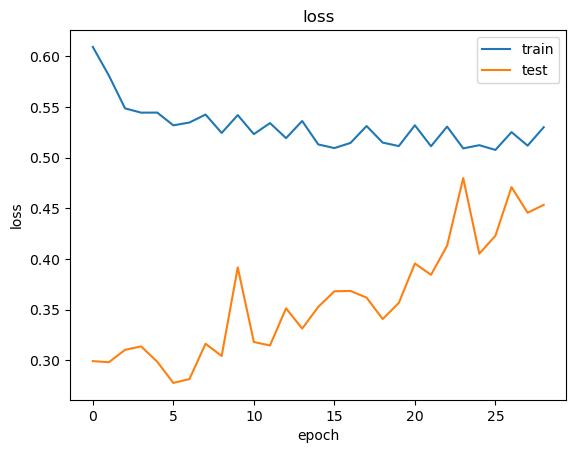

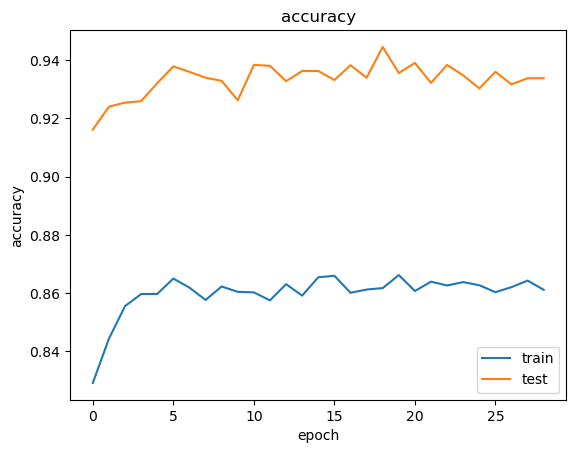

In [40]:
model = Perceptron(28*28, 512, 10, 0.5).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

torch.set_float32_matmul_precision('high')
torch.compile(model)

metrics = {
    'train': Metrics(),
    'test': Metrics()
}

for epoch in range(1, 30):
    train(model, criterion, optimizer, loaders['train'], metrics['train'], device)
    test(model, criterion, loaders['test'], metrics['test'], device)


plot(metrics, 'loss')
show()

plot(metrics, 'accuracy')
show()

for metric in metrics.values():
    metric.reset()